In [1]:
!pip install gym pygame torch numpy matplotlib

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import time
import pygame
from flappy_custom_env import FlappyBirdEnv

In [ ]:
GAMMA = 0.99
LR = 1e-4
BATCH_SIZE = 64
BUFFER_SIZE = 50000
MIN_REPLAY_SIZE = 1000
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.995
TARGET_UPDATE_FREQ = 10
NUM_EPISODES = 500
ENABLE_RENDERING = False

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states),
                np.array(actions),
                np.array(rewards, dtype=np.float32),
                np.array(next_states),
                np.array(dones, dtype=np.float32))

    def __len__(self):
        return len(self.buffer)

In [ ]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

Episode 1: Reward = -61.00, Epsilon = 0.995
Episode 2: Reward = -60.00, Epsilon = 0.990
Episode 3: Reward = -57.00, Epsilon = 0.985
Episode 4: Reward = -60.00, Epsilon = 0.980
Episode 5: Reward = -62.00, Epsilon = 0.975
Episode 6: Reward = -57.00, Epsilon = 0.970
Episode 7: Reward = -52.00, Epsilon = 0.966
Episode 8: Reward = -58.00, Epsilon = 0.961
Episode 9: Reward = -54.00, Epsilon = 0.956
Episode 10: Reward = -59.00, Epsilon = 0.951
Episode 11: Reward = -60.00, Epsilon = 0.946
Episode 12: Reward = -58.00, Epsilon = 0.942
Episode 13: Reward = -58.00, Epsilon = 0.937
Episode 14: Reward = -59.00, Epsilon = 0.932
Episode 15: Reward = -52.00, Epsilon = 0.928
Episode 16: Reward = -60.00, Epsilon = 0.923
Episode 17: Reward = -61.00, Epsilon = 0.918
Episode 18: Reward = -62.00, Epsilon = 0.914
Episode 19: Reward = -44.00, Epsilon = 0.909
Episode 20: Reward = -60.00, Epsilon = 0.905
Episode 21: Reward = -62.00, Epsilon = 0.900
Episode 22: Reward = -62.00, Epsilon = 0.896
Episode 23: Reward 

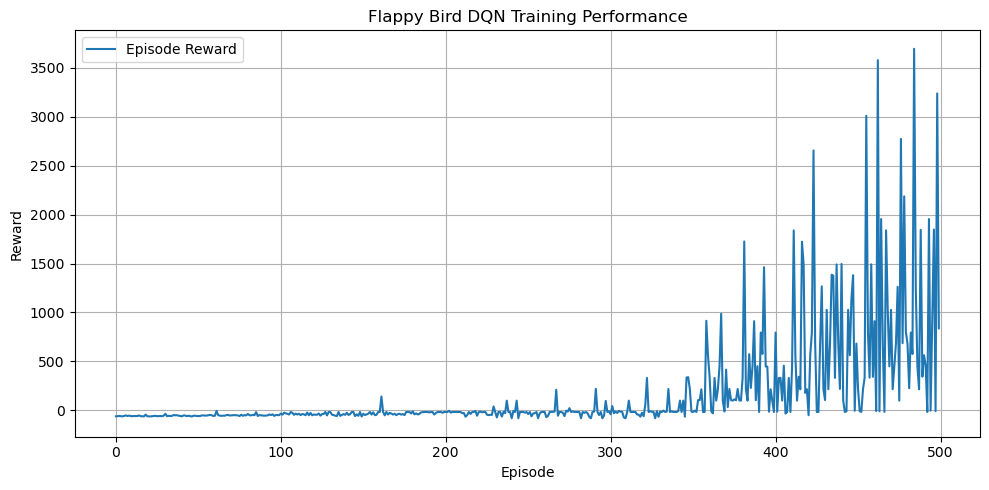

In [43]:
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.q_net = QNetwork(state_dim, action_dim)
        self.target_net = QNetwork(state_dim, action_dim)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=LR)
        self.replay_buffer = ReplayBuffer(BUFFER_SIZE)
        self.epsilon = EPS_START
        self.action_dim = action_dim

    def act(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.q_net(state_tensor)
        return q_values.argmax().item()

    def update(self):
        if len(self.replay_buffer) < MIN_REPLAY_SIZE:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(BATCH_SIZE)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)

        current_q = self.q_net(states).gather(1, actions)
        next_q = self.target_net(next_states).max(1, keepdim=True)[0]
        expected_q = rewards + GAMMA * next_q * (1 - dones)

        loss = F.mse_loss(current_q, expected_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

try:
    env = FlappyBirdEnv()
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    agent = DQNAgent(state_dim, action_dim)
    rewards_history = []

    for episode in range(NUM_EPISODES):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)

            if ENABLE_RENDERING:
                env.render()
                pygame.event.pump()
                time.sleep(1 / 60)

            agent.replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            agent.update()

        if agent.epsilon > EPS_END:
            agent.epsilon *= EPS_DECAY

        if episode % TARGET_UPDATE_FREQ == 0:
            agent.target_net.load_state_dict(agent.q_net.state_dict())

        rewards_history.append(total_reward)
        print(f"Episode {episode + 1}: Reward = {total_reward:.2f}, Epsilon = {agent.epsilon:.3f}")

except Exception as e:
    print(f"[ERROR] Training crashed: {e}")

finally:
    env.close()
    pygame.quit()

In [44]:
ENABLE_RENDERING = True
NUM_EVAL_EPISODES = 5

for ep in range(NUM_EVAL_EPISODES):
    state = env.reset()
    done = False
    total = 0
    while not done:
        env.render()
        pygame.event.pump()
        action = agent.act(state)
        state, reward, done, _ = env.step(action)
        total += reward
        time.sleep(1/60)

    print(f"Evaluation Episode {ep + 1}: Reward = {total:.2f}")

env.close()
pygame.quit() 

Evaluation Episode 1: Reward = -16.00
Evaluation Episode 2: Reward = 648.00
Evaluation Episode 3: Reward = -51.00
Evaluation Episode 4: Reward = 423.00
Evaluation Episode 5: Reward = 154.00


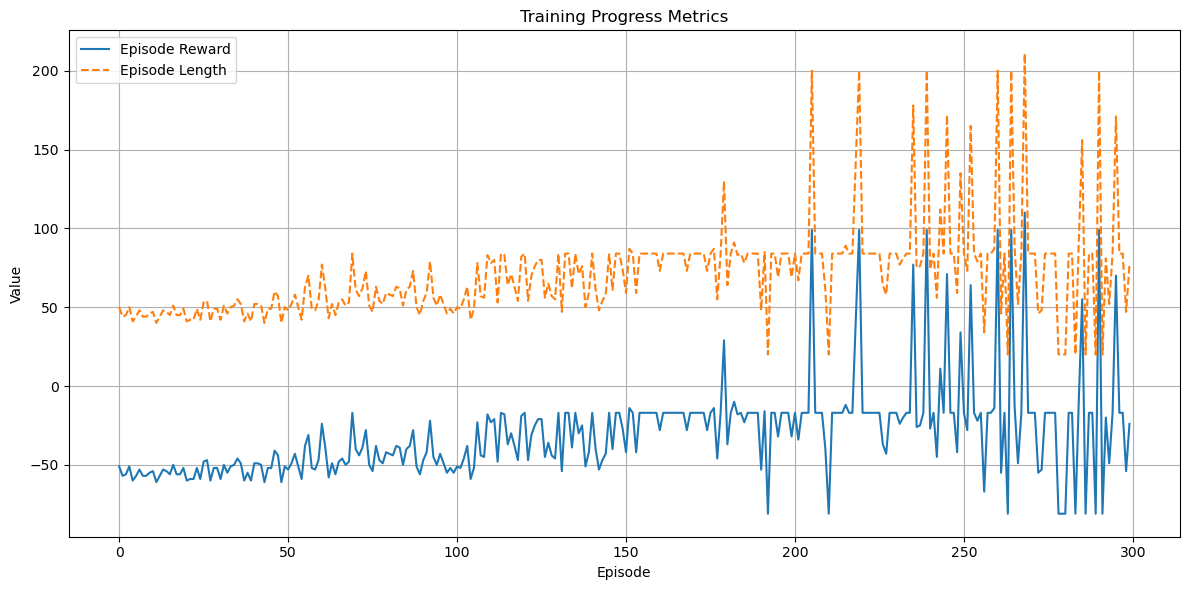

In [45]:
metric_df = pd.read_csv("results/metric.csv")
plt.figure(figsize=(12,6))
plt.plot(metric_df['episode'], metric_df['reward'], label='Episode Reward')
plt.plot(metric_df['episode'], metric_df['length'], label='Episode Length', linestyle='--')
plt.xlabel("Episode")
plt.ylabel("Value")
plt.title("Training Progress Metrics")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/training_progress.png")
plt.show()

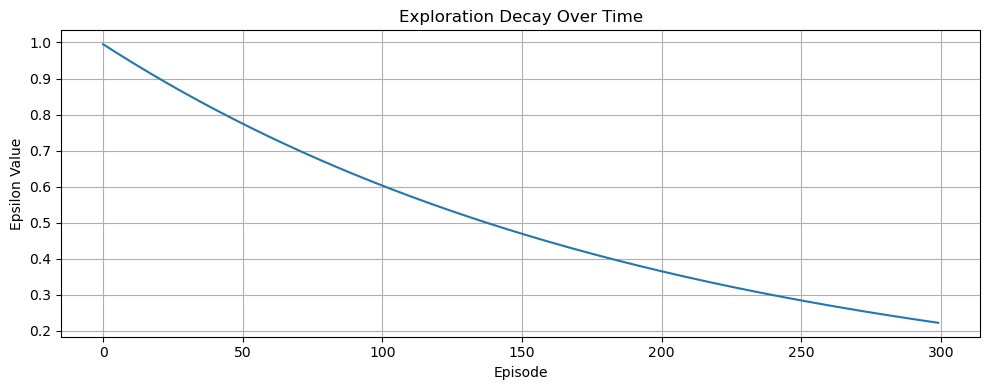

In [46]:
plt.figure(figsize=(10,4))
plt.plot(metric_df['episode'], metric_df['epsilon'], label='Epsilon')
plt.xlabel("Episode")
plt.ylabel("Epsilon Value")
plt.title("Exploration Decay Over Time")
plt.grid()
plt.tight_layout()
plt.savefig("results/epsilon_decay.png")
plt.show()